# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust. 

1. Gathering data
2. Quick EDA
3. Preprocess
4. Extract features
5. Build a LSTM
6. Evaluate and conclude

Datasets:
* Crowd-sourced Emotional Multimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto Emotional Speech Set (Tessa)

# 1. Gathering data

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded. 

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/cremad/AudioWAV/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav,male,happy
1,/kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav,female,fear
2,/kaggle/input/cremad/AudioWAV/1056_IEO_ANG_HI.wav,female,angry
3,/kaggle/input/cremad/AudioWAV/1038_IEO_SAD_HI.wav,male,sad
4,/kaggle/input/cremad/AudioWAV/1043_IEO_DIS_HI.wav,female,disgust


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear


**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
1,/kaggle/input/surrey-audiovisual-expressed-emo...,male,fear
2,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
3,/kaggle/input/surrey-audiovisual-expressed-emo...,male,disgust
4,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry


In [7]:
savee_df.shape

(420, 3)

In [8]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [9]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [10]:
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


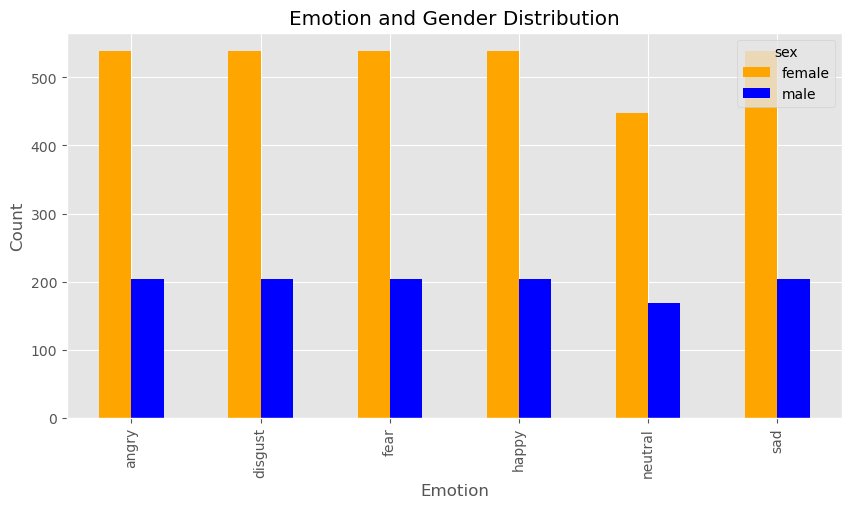

In [11]:
import matplotlib.pyplot as plt

def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(10, 5), color=['orange', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')

    # Save the plot as a PNG file
    plt.savefig('/kaggle/working/emotion_gender_distribution.png')
    
    # Display the plot
    plt.show()

# Assuming df is your DataFrame
plot_distribution(df)


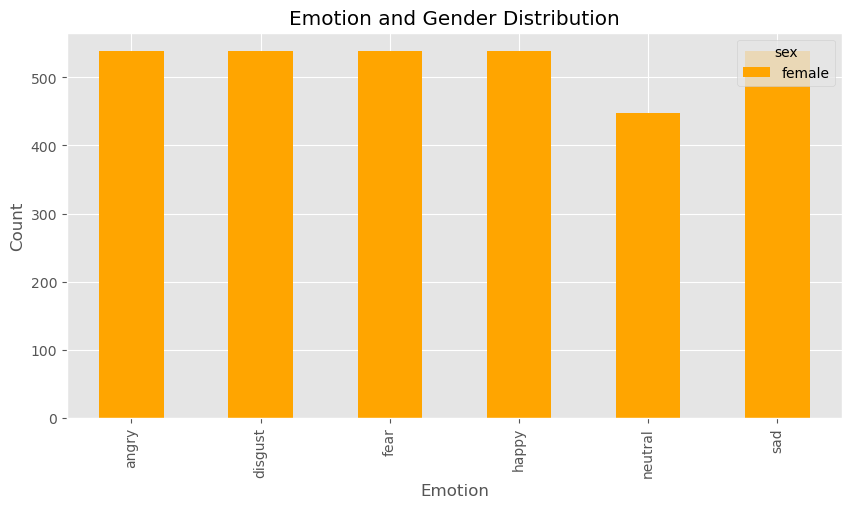

In [12]:
# I decided to go with a female specific model 
df = df[df['sex'] == 'female']
plot_distribution(df)

In [13]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,fear


In [14]:
df['emotion'].value_counts()

disgust    539
fear       539
sad        539
happy      539
angry      539
neutral    448
Name: emotion, dtype: int64

In [15]:
from IPython.display import Audio

def create_waveplot(y, sr, title, filename):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.savefig(filename)
    plt.show()

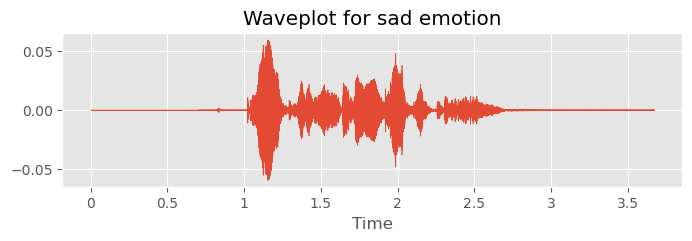

In [16]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

# Specify the filename to save the plot
filename = '/kaggle/working/waveplot.png'

create_waveplot(y, sr, title, filename)

# Display the audio
Audio(path)

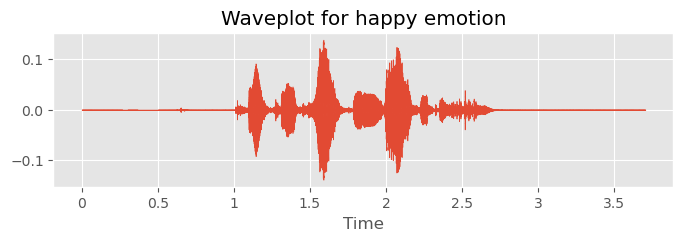

In [17]:
emotion_label = 'happy'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

# Specify the filename to save the plot
filename = f'/kaggle/working/{emotion_label}_wave.png'

create_waveplot(y, sr, title, filename)

# Display the audio
Audio(path)

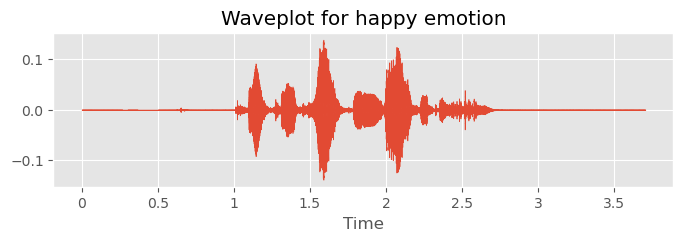

In [18]:
emotion_label = 'happy'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

# Specify the filename to save the plot
filename = f'/kaggle/working/{emotion_label}_wave.png'

create_waveplot(y, sr, title, filename)

# Display the audio
Audio(path)

# 3. Preprocess

The following steps will be followed to preprocess the audio: 

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length

In [19]:
from pydub import AudioSegment, effects

In [20]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [21]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# 4. Extract features

We will only extract these features: 

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [22]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


In [23]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

# 5. Build a LSTM

Before building the model, we will have to setup the data. LSTM are great for sequences.  

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [25]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [26]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [27]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53,894
Trainable params: 53,894
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/200
461/461 [==============================] - 19s 21ms/step - loss: 1.4397 - categorical_accuracy: 0.3813 - val_loss: 1.2306 - val_categorical_accuracy: 0.4432
Epoch 2/200
461/461 [==============================] - 8s 18ms/step - loss: 1.2373 - categorical_accuracy: 0.4812 - val_loss: 1.2100 - val_categorical_accuracy: 0.5265
Epoch 3/200
461/461 [==============================] - 9s 19ms/step - loss: 1.1316 - categorical_accuracy: 0.5449 - val_loss: 1.2602 - val_categorical_accuracy: 0.4394
Epoch 4/200
461/461 [==============================] - 8s 18ms/step - loss: 1.0691 - categorical_accuracy: 0.5760 - val_loss: 1.0118 - val_categorical_accuracy: 0.6061
Epoch 5/200
461/461 [==============================] - 8s 18ms/step - loss: 1.0391 - categorical_accuracy: 0.5915 - val_loss: 0.9973 - val_categorical_accuracy: 0.6136
Epoch 6/200
461/461 [==============================] - 8s 18ms/step - loss: 0.9931 - categorical_accuracy: 0.6198 - val_loss: 0.9485 - val_categorical_accuracy

# 6. Evaluate and conclude

Let's see how good are model is. 

In [29]:
from sklearn.metrics import confusion_matrix

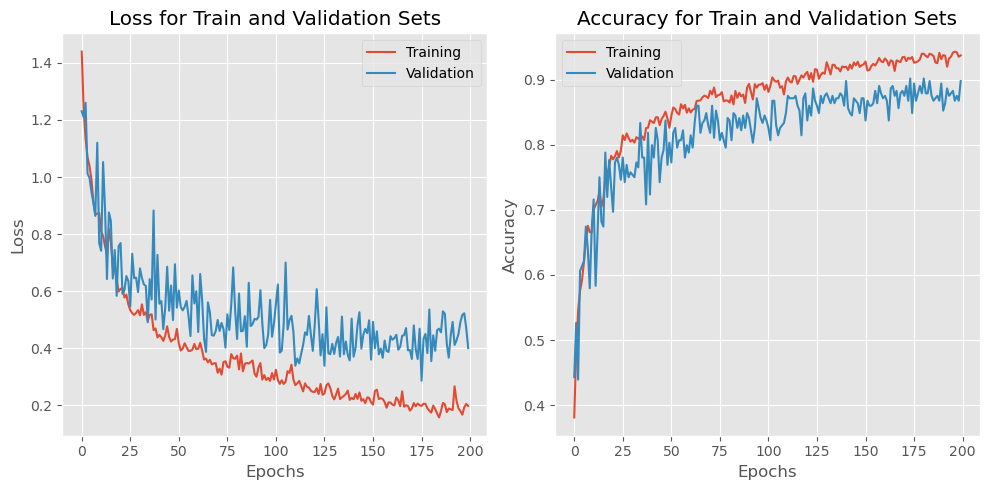

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

9/9 [==============================] - 1s 18ms/step


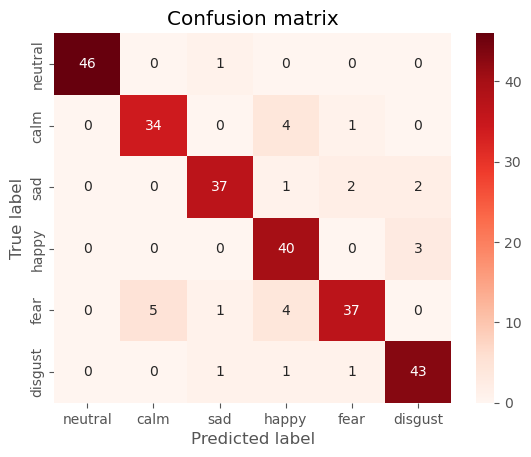

In [31]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [32]:
MODEL1 = Sequential()
MODEL1.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL1.add(layers.LSTM(64))
MODEL1.add(layers.Dense(128, activation='relu'))
MODEL1.add(layers.Dense(6, activation='softmax'))

print(MODEL1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 352, 64)           20480     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 62,598
Trainable params: 62,598
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL1.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL1.fit(X_train, y_train_class, epochs=100, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/100
461/461 [==============================] - 13s 20ms/step - loss: 1.5579 - categorical_accuracy: 0.3082 - val_loss: 1.4153 - val_categorical_accuracy: 0.3561
Epoch 2/100
461/461 [==============================] - 9s 19ms/step - loss: 1.3865 - categorical_accuracy: 0.4117 - val_loss: 1.3523 - val_categorical_accuracy: 0.4470
Epoch 3/100
461/461 [==============================] - 9s 19ms/step - loss: 1.2820 - categorical_accuracy: 0.4700 - val_loss: 1.3361 - val_categorical_accuracy: 0.4773
Epoch 4/100
461/461 [==============================] - 9s 19ms/step - loss: 1.2105 - categorical_accuracy: 0.5156 - val_loss: 1.1315 - val_categorical_accuracy: 0.5455
Epoch 5/100
461/461 [==============================] - 8s 18ms/step - loss: 1.0733 - categorical_accuracy: 0.5716 - val_loss: 1.0014 - val_categorical_accuracy: 0.6098
Epoch 6/100
461/461 [==============================] - 9s 18ms/step - loss: 0.9649 - categorical_accuracy: 0.6190 - val_loss: 0.9047 - val_categorical_accuracy

In [34]:
MODEL2 = Sequential()
MODEL2.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL2.add(layers.LSTM(128))
MODEL2.add(layers.Dense(128, activation='relu'))
MODEL2.add(layers.Dense(64, activation='relu'))
MODEL2.add(layers.Dense(6, activation='softmax'))

print(MODEL2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 352, 64)           20480     
                                                                 
 lstm_5 (LSTM)               (None, 128)               98816     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 144,454
Trainable params: 144,454
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL2.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL2.fit(X_train, y_train_class, epochs=100, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/100
461/461 [==============================] - 14s 22ms/step - loss: 1.5756 - categorical_accuracy: 0.3158 - val_loss: 1.4849 - val_categorical_accuracy: 0.3826
Epoch 2/100
461/461 [==============================] - 10s 21ms/step - loss: 1.3585 - categorical_accuracy: 0.4287 - val_loss: 1.2546 - val_categorical_accuracy: 0.4432
Epoch 3/100
461/461 [==============================] - 10s 21ms/step - loss: 1.2862 - categorical_accuracy: 0.4566 - val_loss: 1.1955 - val_categorical_accuracy: 0.5303
Epoch 4/100
461/461 [==============================] - 9s 20ms/step - loss: 1.1880 - categorical_accuracy: 0.5159 - val_loss: 1.1511 - val_categorical_accuracy: 0.5114
Epoch 5/100
461/461 [==============================] - 9s 20ms/step - loss: 1.1536 - categorical_accuracy: 0.5347 - val_loss: 1.2852 - val_categorical_accuracy: 0.5379
Epoch 6/100
461/461 [==============================] - 9s 20ms/step - loss: 1.0736 - categorical_accuracy: 0.5669 - val_loss: 1.0315 - val_categorical_accura

**Conclusion**

In summary, our model achieved 90% accuracy in classifying six different emotions. However, there are several ways we could improve it. For example, we could change the model, obtain a better dataset and extract different features. One optimization that we could make is to generate a codebook and apply vector quantization to reduce the dimensionality. This can help to improve the model's training speed and reduce the risk of overfitting. Lastly, don't forget to use accelerators to speed up the training process. 